In [ ]:
#@title Dependência

!pip install -U g4f[all] -q
!pip install yt_dlp -q
!pip install ffmpeg-python -q
!pip install git+https://github.com/m-bain/whisperx.git -q

In [ ]:
#@title Áudio Mudo
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

In [ ]:
#@title Vídeo Youtube
import os
import yt_dlp

# URL do vídeo (substitua pela URL desejada)
url = 'https://www.youtube.com/watch?v=ZW6mDPX6Zwc'  # @param {type: "string"}

# Função de Download de Vídeo
def download_video(url, filename):
    output_path = f'tmp/{filename}'

    # Cria o diretório tmp se não existir
    os.makedirs('tmp', exist_ok=True)

    if os.path.exists(output_path):
        print(f"O arquivo {output_path} já existe. Pulando o download.")
        return

    ydl_opts = {
        'format': 'bestvideo+bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4'
        }],
        'outtmpl': output_path,
        'postprocessor_args': [
            '-movflags', 'faststart'
        ],
        'merge_output_format': 'mp4'
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

# Chame a função de download
if url:
    download_video(url, 'input_video.mp4')
else:
    print("Por favor, forneça uma URL de vídeo válida.")



[youtube] Extracting URL: https://www.youtube.com/watch?v=ZW6mDPX6Zwc
[youtube] ZW6mDPX6Zwc: Downloading webpage
[youtube] ZW6mDPX6Zwc: Downloading ios player API JSON
[youtube] ZW6mDPX6Zwc: Downloading web creator player API JSON
[youtube] ZW6mDPX6Zwc: Downloading m3u8 information
[info] ZW6mDPX6Zwc: Downloading 1 format(s): 313+251
[download] Destination: tmp/input_video.f313.webm
[download] 100% of  430.37MiB in 00:00:27 at 15.50MiB/s  
[download] Destination: tmp/input_video.f251.webm
[download] 100% of   10.31MiB in 00:00:01 at 7.91MiB/s   
[Merger] Merging formats into "tmp/input_video.mp4"
Deleting original file tmp/input_video.f251.webm (pass -k to keep)
Deleting original file tmp/input_video.f313.webm (pass -k to keep)
[VideoConvertor] Not converting media file "tmp/input_video.mp4"; already is in target format mp4


In [ ]:
#@title Transcrição
#@markdown <b>Essa parte demora um pouco pois botei pra sincronizar bem, pois as falas são importantes para cortar nas partes certas e não terminar sem sentido.
import os
import subprocess

model = 'large-v3'  # @param ["tiny", "small", "medium", "large", "large-v1", "large-v2", "large-v3"]

def srt_to_tsv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
        subtitle_lines = f_in.read().strip().split('\n\n')

        for subtitle_block in subtitle_lines:
            subtitle = subtitle_block.strip().split('\n')

            subtitle_number = subtitle[0]
            time_range = subtitle[1]
            subtitle_text = ' '.join(subtitle[2:])

            f_out.write(f"{subtitle_number}\t{time_range}\t{subtitle_text}\n")

def generate_whisperx(input_file, output_folder):
    output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}.srt")

    command = f"""
      whisperx {input_file} \
      --model {model} \
      --task transcribe \
      --align_model WAV2VEC2_ASR_LARGE_LV60K_960H \
      --interpolate_method linear \
      --chunk_size 10 \
      --verbose True \
      --vad_onset 0.4 \
      --vad_offset 0.3 \
      --no_align \
      --segment_resolution sentence \
      --compute_type float32 \
      --batch_size 10 \
      --output_dir {output_folder} \
      --output_format srt \
      --print_progress True
    """

    print("Transcrevendo...")

    result = subprocess.run(command, shell=True, text=True, capture_output=True)

    if result.returncode != 0:
        print("Erro durante a transcrição:")
        print(result.stderr)
    else:
        print(f"Transcrição concluída. Arquivo salvo em: {output_file}")

# Define o caminho do arquivo de entrada e o diretório de saída
input_file = '/content/tmp/input_video.mp4'
output_folder = '/content/tmp'

# Chama a função de transcrição
generate_whisperx(input_file, output_folder)

srt_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}.srt")
tsv_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}.tsv")

if os.path.exists(srt_file):
    srt_to_tsv(srt_file, tsv_file)
else:
    print(f"O arquivo SRT não foi encontrado: {srt_file}")




whisperx /content/tmp/input_video.mp4 --output_dir /content/tmp --output_format srt --task transcribe
Transcrição concluída. Arquivo salvo em: /content/tmp/input_video.srt


In [ ]:
#@title Criar viral
#@markdown <h1><b>Copie o resultado e jogue no chatgpt <br><br> Se o vídeo for maior que 10 minutos terá que enviar algumas partes pro chatgpt.

# Load the TSV file

quantidade_de_virals = 3  # @param {type:"number"}

with open('/content/tmp/input_video.tsv', 'r', encoding='utf-8') as f:
    content = f.read()

system = f"You are a Viral Segment Identifier, an AI system that analyzes a video's transcript and predicts which segments might go viral on social media platforms. You use factors such as emotional impact, humor, unexpected content, and relevance to current trends to make your predictions. You return a structured text document detailing the start and end times, the description, the duration, and a viral score for the potential viral segments."

tempo_minimo = 50  # @param {type:"number"}
tempo_maximo = 90  # @param {type:"number"}

json_template = '''
        { "segments" :
            [
                {
                    "title": "Suggested Viral Title",
                    "start_time": "00:00:00", #HH:MM:SS
                    "end_time": "00:00:00", #HH:MM:SS
                    "description": "Description of the text",
                    "duration": 0,
                    "score": 0  # Probability of going viral (0-100)
                }
            ]
        }
    '''

# Split content into chunks of 14,000 characters without cutting lines
chunk_size = 17400
chunks = []
start = 0

while start < len(content):
    end = min(start + chunk_size, len(content))
    if end < len(content):
        end = content.rfind('\n', start, end)  # Find last newline before chunk size
        if end == -1:  # No newline found, just take the chunk size
            end = start + chunk_size
    chunks.append(content[start:end])
    start = end

# Prepare the output texts
output_texts = []
for i, chunk in enumerate(chunks):
    if len(chunks) == 1:
        output_text = f"""
{system}\n
Given the following video transcript, analyze the part for potential virality and identify {quantidade_de_virals} most viral segments from the transcript. Each segment must have a duration between {tempo_minimo} and {tempo_maximo} seconds. It is MANDATORY to respect the specified number of viral segments, the minimum duration, and the maximum duration. Additionally, the cuts MUST MAKE SENSE and cannot end abruptly without context. The provided transcript is as follows:
{chunk}
Based on your analysis, return a structured text document containing the timestamps (start and end), the description of the viral part, its duration, a suggested viral title, and a score indicating the probability of going viral. Please follow this format for each segment.
{json_template}
"""
    else:
        if i == 0:
            output_text = f"""
{chunk}
"""
        elif i < len(chunks) - 1:
            output_text = f"""
Vou enviar outra parte da legenda, analise e responda com OK, assim envio mais partes da legenda.

{chunk}
"""
        else:
            output_text = f"""
Vou enviar outra parte da legenda, analise e responda com OK, assim envio mais partes da legenda.

{chunk}\n\n
{system}\n
Given the following video transcript, analyze each part for potential virality and identify {quantidade_de_virals} most viral segments from the transcript. Each segment must have a duration between {tempo_minimo} and {tempo_maximo} seconds. It is MANDATORY to respect the specified number of viral segments, the minimum duration, and the maximum duration. Additionally, the cuts MUST MAKE SENSE and cannot end abruptly without context. The provided transcript is as follows:
Based on your analysis, return a structured text document containing the timestamps (start and end), the description of the viral part, its duration, a suggested viral title, and a score indicating the probability of going viral. Please follow this format for each segment.
{json_template}
"""

    output_texts.append(output_text)

# Print the output texts
for text in output_texts:
    print(text)




You are a Viral Segment Identifier, an AI system that analyzes a video's transcript and predicts which segments might go viral on social media platforms. You use factors such as emotional impact, humor, unexpected content, and relevance to current trends to make your predictions. You return a structured text document detailing the start and end times, the description, the duration, and a viral score for the potential viral segments.

Given the following video transcript, analyze each part for potential virality and identify 3 most viral segments from the transcript. Each segment should have a duration between 50 and 90 seconds. The provided transcript is as follows:
1	00:00:00,089 --> 00:00:01,390	Eu tenho alergia.
2	00:00:01,750 --> 00:00:02,631	E não sou só eu.
3	00:00:02,871 --> 00:00:06,534	Mais de 2 bilhões de pessoas ao redor do mundo têm algum tipo de alergia.
4	00:00:06,674 --> 00:00:07,935	E esse número só cresce.
5	00:00:08,195 --> 00:00:10,757	Nos últimos 30 anos a coisa pi

Exemplo de resposta<br>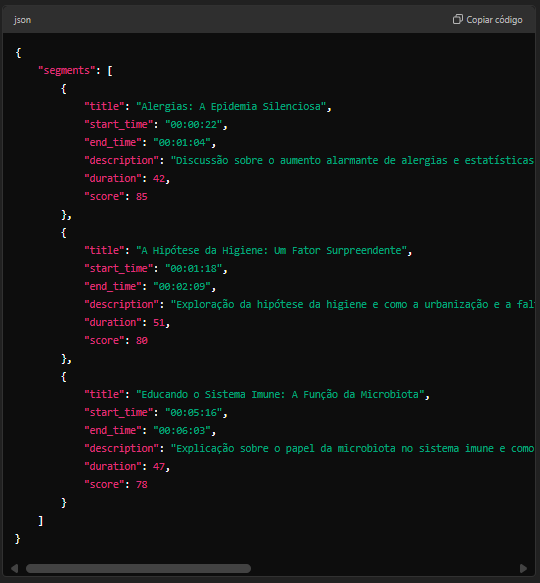

In [ ]:
#@title Dê play e coloque o resultado do chatgpt aqui
#@markdown <h1><b> ATENÇÃO: Você deve colar a resposta do chatgpt aqui.<br><h2>Similar a imagem acima
import json

def save_viral_segments():
    # Solicita ao usuário que insira o JSON
    user_input = input("Por favor, insira o JSON no formato desejado:\n")

    try:
        # Tenta carregar o JSON inserido
        segments_data = json.loads(user_input)

        # Valida se o formato está correto
        if "segments" in segments_data and isinstance(segments_data["segments"], list):
            output_txt_file = "/content/tmp/viral_segments.txt"

            # Salva os dados em um arquivo JSON
            with open(output_txt_file, 'w', encoding='utf-8') as file:
                json.dump(segments_data, file, ensure_ascii=False, indent=4)

            print(f"Segmentos virais salvos em {output_txt_file}")
        else:
            print("Formato inválido. Certifique-se de que a estrutura está correta.")
    except json.JSONDecodeError:
        print("Erro ao decifrar o JSON. Por favor, verifique a formatação.")

# Chama a função para executar
save_viral_segments()


Por favor, insira o JSON no formato desejado:
{     "segments": [         {             "title": "Alergias: A Epidemia Silenciosa",             "start_time": "00:00:22",             "end_time": "00:01:04",             "description": "Discussão sobre o aumento alarmante de alergias e estatísticas sobre asma e reações alérgicas, despertando preocupação e identificação do público.",             "duration": 42,             "score": 85         },         {             "title": "A Hipótese da Higiene: Um Fator Surpreendente",             "start_time": "00:01:18",             "end_time": "00:02:09",             "description": "Exploração da hipótese da higiene e como a urbanização e a falta de exposição a bactérias estão relacionados ao aumento das alergias, gerando curiosidade e reflexão.",             "duration": 51,             "score": 80         },         {             "title": "Educando o Sistema Imune: A Função da Microbiota",             "start_time": "00:05:16",             "end_tim

In [ ]:
#@title Cortar segmentos
#@markdown <h1><b>Obviamente quanto mais cortes escolher ou maior o tempo, MAIS irá demorar pra processar.
import subprocess
import json
import os

def check_nvenc_support():
    try:
        result = subprocess.run(["ffmpeg", "-encoders"], capture_output=True, text=True)
        return "h264_nvenc" in result.stdout
    except subprocess.CalledProcessError:
        return False

def generate_segments(response):
    if not check_nvenc_support():
        print("NVENC is not supported on this system. Falling back to libx264.")
        video_codec = "libx264"
    else:
        video_codec = "h264_nvenc"

    input_file = "/content/tmp/input_video.mp4"
    if not os.path.exists(input_file):
        print(f"Input file not found: {input_file}")
        return

    segments = response.get("segments", [])
    for i, segment in enumerate(segments):
        start_time = segment.get("start_time", "00:00:00")
        duration = segment.get("duration", 0)  # Utiliza a duração para calcular o corte

        output_file = f"output{str(i).zfill(3)}_original_scale.mp4"

        # Comando ffmpeg ajustado para usar -ss antes de -i e -t para a duração
        command = [
            "ffmpeg",
            "-y",
            "-ss", start_time,          # Corte antes de decodificar
            "-i", input_file,
            "-t", str(duration),        # Define a duração do segmento
            "-c:v", video_codec
        ]

        if video_codec == "h264_nvenc":
            command.extend([
                "-preset", "p1",  # Fast encoding preset for NVENC
                "-b:v", "5M",     # Set bitrate instead of CRF for NVENC
            ])
        else:
            command.extend([
                "-preset", "ultrafast",
                "-crf", "23"
            ])

        command.extend([
            "-c:a", "aac",
            "-b:a", "128k",
            f"/content/tmp/{output_file}"
        ])

        print(f"Processing segment {i+1}/{len(segments)}")
        print(f"Start time: {start_time}, Duration: {duration} seconds")
        print(f"Executing command: {' '.join(command)}")

        # Executando o comando
        try:
            result = subprocess.run(command, check=True, capture_output=True, text=True)
            #print(f"Command output: {result.stdout}")
            #print(f"Command error output: {result.stderr}")
        except subprocess.CalledProcessError as e:
            print(f"Error executing ffmpeg: {e}")
            #print(f"Error output: {e.stderr}")
            continue

        if os.path.exists(f"/content/tmp/{output_file}"):
            file_size = os.path.getsize(f"/content/tmp/{output_file}")
            print(f"Generated segment: {output_file}, Size: {file_size} bytes")
        else:
            print(f"Failed to generate segment: {output_file}")

        print("\n" + "="*50 + "\n")

# Reading the JSON file
with open('/content/tmp/viral_segments.txt', 'r') as file:
    response = json.load(file)

generate_segments(response)


Processing segment 1/3
Start time: 00:01:18, Duration: 51 seconds
Executing command: ffmpeg -y -ss 00:01:18 -i /content/tmp/input_video.mp4 -t 51 -c:v h264_nvenc -preset p1 -b:v 5M -c:a aac -b:a 128k /content/tmp/output000_original_scale.mp4
Generated segment: output000_original_scale.mp4, Size: 34625607 bytes


Processing segment 2/3
Start time: 00:04:48, Duration: 53 seconds
Executing command: ffmpeg -y -ss 00:04:48 -i /content/tmp/input_video.mp4 -t 53 -c:v h264_nvenc -preset p1 -b:v 5M -c:a aac -b:a 128k /content/tmp/output001_original_scale.mp4
Generated segment: output001_original_scale.mp4, Size: 23980161 bytes


Processing segment 3/3
Start time: 00:08:42, Duration: 77 seconds
Executing command: ffmpeg -y -ss 00:08:42 -i /content/tmp/input_video.mp4 -t 77 -c:v h264_nvenc -preset p1 -b:v 5M -c:a aac -b:a 128k /content/tmp/output002_original_scale.mp4
Generated segment: output002_original_scale.mp4, Size: 47286045 bytes




In [ ]:
#@title Ajustar rosto
import cv2
import subprocess
import os

# Função de Segmentação de Vídeo
def generate_short(input_file, output_file, index):
    try:
        # Intervalo para mudar as faces (em frames)
        switch_interval = 150

        # Contador de frames
        frame_count = 0

        # Índice da face atualmente exibida
        current_face_index = 0

        # Carregar o detector de faces
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Abrir o arquivo de vídeo
        cap = cv2.VideoCapture(input_file)

        # Verifica se o vídeo foi aberto corretamente
        if not cap.isOpened():
            print(f"Erro ao abrir o vídeo: {input_file}")
            return

        # Obter FPS e dimensões do vídeo original
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(f"Dimensões do vídeo - Altura: {frame_height}, Largura: {frame_width}, FPS: {fps}")

        # Calcular proporção do vídeo original
        original_aspect_ratio = frame_width / frame_height
        target_aspect_ratio = 9 / 16  # Proporção do vídeo vertical (9:16)

        # Definir codec e criar objeto VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_file, fourcc, fps, (1080, 1920))  # Ajustar resolução para 9:16

        # Loop através dos frames do vídeo
        face_positions = []
        while cap.isOpened():
            ret, frame = cap.read()

            if ret:
                # Detectar faces se for hora de mudar
                if frame_count % switch_interval == 0:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=7, minSize=(100, 100))

                    face_positions = []
                    for (x, y, w, h) in faces:
                        face_positions.append((x, y, w, h))
                        if len(face_positions) > 0:
                            current_face_index = 0  # Reiniciar o índice se houver faces detectadas

                # Verificar se há faces detectadas
                if len(face_positions) > 0:
                    # Se houver faces, focar no rosto
                    x, y, w, h = face_positions[current_face_index]
                    face_center = (x + w // 2, y + h // 2)

                    # Calcular as coordenadas do crop para focar no rosto
                    target_height = int(frame_height * 0.8)
                    target_width = int(target_height * target_aspect_ratio)

                    # Calcular as coordenadas do crop
                    crop_x = max(0, face_center[0] - target_width // 2)
                    crop_y = max(0, face_center[1] - target_height // 2)
                    crop_x2 = min(crop_x + target_width, frame_width)
                    crop_y2 = min(crop_y + target_height, frame_height)

                    # Cortar a imagem e redimensionar para 9:16
                    crop_img = frame[crop_y:crop_y2, crop_x:crop_x2]
                    resized = cv2.resize(crop_img, (1080, 1920), interpolation=cv2.INTER_AREA)
                    out.write(resized)
                else:
                    # Nenhuma face detectada, manter proporção 16:9 com barras pretas
                    if original_aspect_ratio > target_aspect_ratio:
                        # Adicionar barras pretas em cima e embaixo (letterbox)
                        new_width = 1080
                        new_height = int(1080 / original_aspect_ratio)
                        resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
                        top_bar = (1920 - new_height) // 2
                        bottom_bar = 1920 - new_height - top_bar
                        black_bars = cv2.copyMakeBorder(resized_frame, top_bar, bottom_bar, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                    else:
                        # Adicionar barras pretas nas laterais (pillarbox)
                        new_height = 1920
                        new_width = int(1920 * original_aspect_ratio)
                        resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
                        left_bar = (1080 - new_width) // 2
                        right_bar = 1080 - new_width - left_bar
                        black_bars = cv2.copyMakeBorder(resized_frame, 0, 0, left_bar, right_bar, cv2.BORDER_CONSTANT, value=[0, 0, 0])

                    out.write(black_bars)

                frame_count += 1

                # Se pressionar 'q', sair do loop
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break

        # Liberar tudo após o término
        cap.release()
        out.release()
        cv2.destroyAllWindows()

        # Extrair áudio do vídeo original
        audio_file = f"tmp/output-audio-{index}.aac"
        command = f"ffmpeg -y -i {input_file} -vn -acodec copy {audio_file}"
        subprocess.call(command, shell=True)

        # Verificar se o arquivo de áudio foi gerado corretamente
        if os.path.exists(audio_file) and os.path.getsize(audio_file) > 0:
            # Criar o diretório final se não existir
            final_dir = "/content/final/"
            os.makedirs(final_dir, exist_ok=True)

            # Mesclar áudio e vídeo processado com h264_nvenc utilizando CUDA, mantendo o bitrate e fps originais
            final_output = os.path.join(final_dir, f"final-output{str(index).zfill(3)}_processed.mp4")
            command = f"ffmpeg -y -i {output_file} -i {audio_file} -c:v h264_nvenc -preset fast -b:v 2M -c:a aac -b:a 192k -r {fps} {final_output}"
            subprocess.call(command, shell=True)

            print(f"Arquivo final gerado em: {final_output}")
        else:
            print(f"Erro ao extrair áudio do vídeo: {input_file}")
    except Exception as e:
        print(f"Erro durante a segmentação do vídeo: {str(e)}")

# Definindo caminhos de entrada e saída
index = 0
while True:  # Permite a execução contínua até não encontrar mais vídeos
    input_file = f'/content/tmp/output{str(index).zfill(3)}_original_scale.mp4'
    output_file = f"tmp/output{str(index).zfill(3)}_processed.mp4"

    # Verificar se o arquivo de entrada existe
    if os.path.exists(input_file):
        # Chamar a função para gerar o vídeo curto
        generate_short(input_file, output_file, index)
    else:
        print(f"Processamento completo até {index - 1} arquivos.")
        break

    index += 1


Dimensões do vídeo - Altura: 2160, Largura: 3840, FPS: 29.97002997002997
Arquivo final gerado em: /content/final/final-output000_processed.mp4
Dimensões do vídeo - Altura: 2160, Largura: 3840, FPS: 29.97002997002997
Arquivo final gerado em: /content/final/final-output001_processed.mp4
Dimensões do vídeo - Altura: 2160, Largura: 3840, FPS: 29.97002997002997
Arquivo final gerado em: /content/final/final-output002_processed.mp4


In [ ]:
#@title Virais criado
#@markdown Irá imprimir ``Segmento 0:``, cada número representa um vídeo para colocar na célula posterior.
import json

# Lê o conteúdo do arquivo viral_segments.txt
with open('/content/tmp/viral_segments.txt', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Itera sobre os segmentos e imprime as informações desejadas
for index, segment in enumerate(data['segments']):
    title = segment['title']
    description = segment['description']
    score = segment['score']
    print(f"Segmento {index}:")
    print(f"  Título: {title}")
    print(f"  Descrição: {description}")
    print(f"  Score: {score}")
    print()


Segmento 0:
  Título: Alergias: A Epidemia Silenciosa
  Descrição: Discussão sobre o aumento alarmante de alergias e estatísticas sobre asma e reações alérgicas, despertando preocupação e identificação do público.
  Score: 85

Segmento 1:
  Título: A Hipótese da Higiene: Um Fator Surpreendente
  Descrição: Exploração da hipótese da higiene e como a urbanização e a falta de exposição a bactérias estão relacionados ao aumento das alergias, gerando curiosidade e reflexão.
  Score: 80

Segmento 2:
  Título: Educando o Sistema Imune: A Função da Microbiota
  Descrição: Explicação sobre o papel da microbiota no sistema imune e como uma microbiota saudável pode ajudar a prevenir alergias, misturando ciência e acessibilidade.
  Score: 78



In [ ]:
#@title Resultado em vídeo
#@markdown <h1><b> Escolha o número do vídeo
from IPython.display import HTML
from base64 import b64encode
import json

numero_do_video = 1 #@param {type:"number"}

def show_video(video_path, video_width=400):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

# Load segment information from the text file
with open('/content/tmp/viral_segments.txt', 'r') as file:
    segments_data = json.load(file)

# Função para exibir o vídeo e as informações correspondentes ao índice
def display_video_with_segment(index):
    try:
        segment = segments_data['segments'][index]

        # Print Title, Description, and Score of the segment
        print(f"Título: {segment['title']}")
        print(f"Descrição: {segment['description']}")
        print(f"Score: {segment['score']}")
        print()

        # Input video
        video_path = f'/content/final/final-output{str(index).zfill(3)}_processed.mp4'
        return show_video(video_path)

    except IndexError:
        print(f"Segmento não encontrado para o índice {index}")
        return None

# Exibir vídeo e informações do segmento correspondente ao índice 0 (por exemplo)
display_video_with_segment(numero_do_video)  # Substitua o índice conforme necessário


Title: O Impacto da Microbiota na Saúde Imune
Description: Discussão sobre a importância da microbiota saudável e como ela ajuda a educar o sistema imunológico, levando a uma menor reação exagerada a substâncias inofensivas.
Score: 88



In [ ]:
#@title Baixar todos os virais gerados
# prompt: Zipar e baixar todos os arquivos da pasta /content/final

!zip -r /content/final.zip /content/final
from google.colab import files
files.download("/content/final.zip")


In [ ]:
#@title Limpar tudo e começar de novo
#@markdown <h1><b>ATENÇÃO: Ao executar essa célula, tudo será apagado e você deve recomeçar na célula onde coloca o <u>LINK</u> do youtube
# prompt: Apagar pasta /content/tmp

!rm -rf /content/tmp
!rm -rf /content/final


#Créditos

Inspirado no [reels clips automator](https://github.com/eddieoz/reels-clips-automator) e no [YoutubeVideoToAIPoweredShorts](https://github.com/Fitsbit/YoutubeVideoToAIPoweredShorts)<br>

---
![Rafa.png](https://i.imgur.com/cGknQpU.png;base64)

Desenvolvido por **Rafa.Godoy**<br>
[Github](https://github.com/RafaelGodoyEbert)<br>
[Instagram](https://www.instagram.com/rafael.godoy.ebert/)<br>
[X](https://x.com/GodoyEbert)
<br>

`0.1v Alpha`<br>

Apenas uma alternativa gratuita ao `opus.pro` e ao `vidyo.ai`<br>
